In [1]:
import os
from datasets import load_dataset

/users/eleves-a/2025/iuliia.korotkova/EmotionalPortraitsGeneration/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_dir = "./data/rafdb_imagefolder"
cache_dir = None

data_files = {}
if train_data_dir is not None:
    data_files["train"] = os.path.join(train_data_dir, "**")
dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
    cache_dir=cache_dir,
)

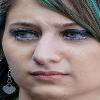

In [3]:
dataset["train"][0]["image"]

In [4]:
dataset["train"][0]["prompt"]

'sad'